In [9]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import numpy as np
import matplotlib.pyplot as plt

import json
import sys
sys.path.append("../../")

from src.context_aware.config import ModelConfig, TrainingConfig, DatasetConfig
from src.dataset_manager import DatasetConvertor 
from src.context_aware.preprocessing import PreparingDataset
from src.context_aware.models import createModel
from src.context_aware.training import trainModel
from src.context_aware.evaluation import evaluateModel

In [10]:
rawDatasetFolder = "../../data/raw"
model_folder = "../../data/models/context_aware"
configPath = "../config/conbined_flows.json"

direction = "forward"
lenWindow = 20
verbose = True

In [11]:
config = json.load(open(configPath, "r"))
mapping = config.get("DIRECTION_MAPPING", {})
dpdr_params = config.get("dpdr_params", {})

datasetConverter = DatasetConvertor(rawDatasetFolder, config)
datasetConverter.processDataset(direction=direction, **dpdr_params[direction])
dataUnit = datasetConverter.getDataUnit(f"combined_{mapping[direction]}")
datasetConfig = DatasetConfig.initialize(len_window=lenWindow, data_augment=True)
trainData, testData = PreparingDataset(dataUnit, datasetConfig, verbose=False)

modelConfig = ModelConfig.from_dataset(datasetConfig, trainData)
model, device = createModel(modelConfig)

trainingConfig = TrainingConfig()
model, avg_train_loss_history, avg_test_loss_history = trainModel(
    model, trainData, testData, trainingConfig, verbose=verbose
)
model.save_checkpoint(f"{model_folder}/direction_{direction}_lenWindow_{lenWindow}.pth")

========== Combined ============
Forward: Compression rate: 0.2328


KeyboardInterrupt: 

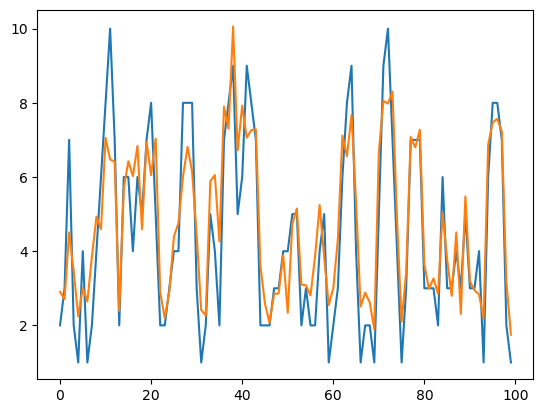

In [ ]:
datasetConfig = DatasetConfig.initialize(len_window=lenWindow, data_augment=False)
_, testData = PreparingDataset(dataUnit, datasetConfig, verbose=False)
model, device = createModel(modelConfig)
model.load_checkpoint(f"{model_folder}/direction_{direction}_lenWindow_{lenWindow}.pth")
results = evaluateModel(model, testData)

plt.plot(results['trafficTarget_actual'][0:100])
plt.plot(results['trafficTarget_predicted'][0:100])
plt.show()